## Predicting Top 50 S&P 500 Stock Market Prices using Linear Regression

This project aims to predict Top 50 S&P 500 Stock Market Prices using Linear Regression. The dataset was collected from YahooFinance API ranging from 2015-2020. For the data collection, cleaning and exploratory data analysis, this can be viewed in the separate notebook entitled 'EDA - Predicting Top 50 S&P 500 Stock Market Prices' under the same repository. 

As a proof of concept, our dataset will be ranging from January 1, 2015 to December 30, 2020 and as a limitation, on top of the volatile nature of stock market, the price predictions in this project are only based on previous closing prices and does not include external factors such as macroeconomy, political climate, and company performance etc.


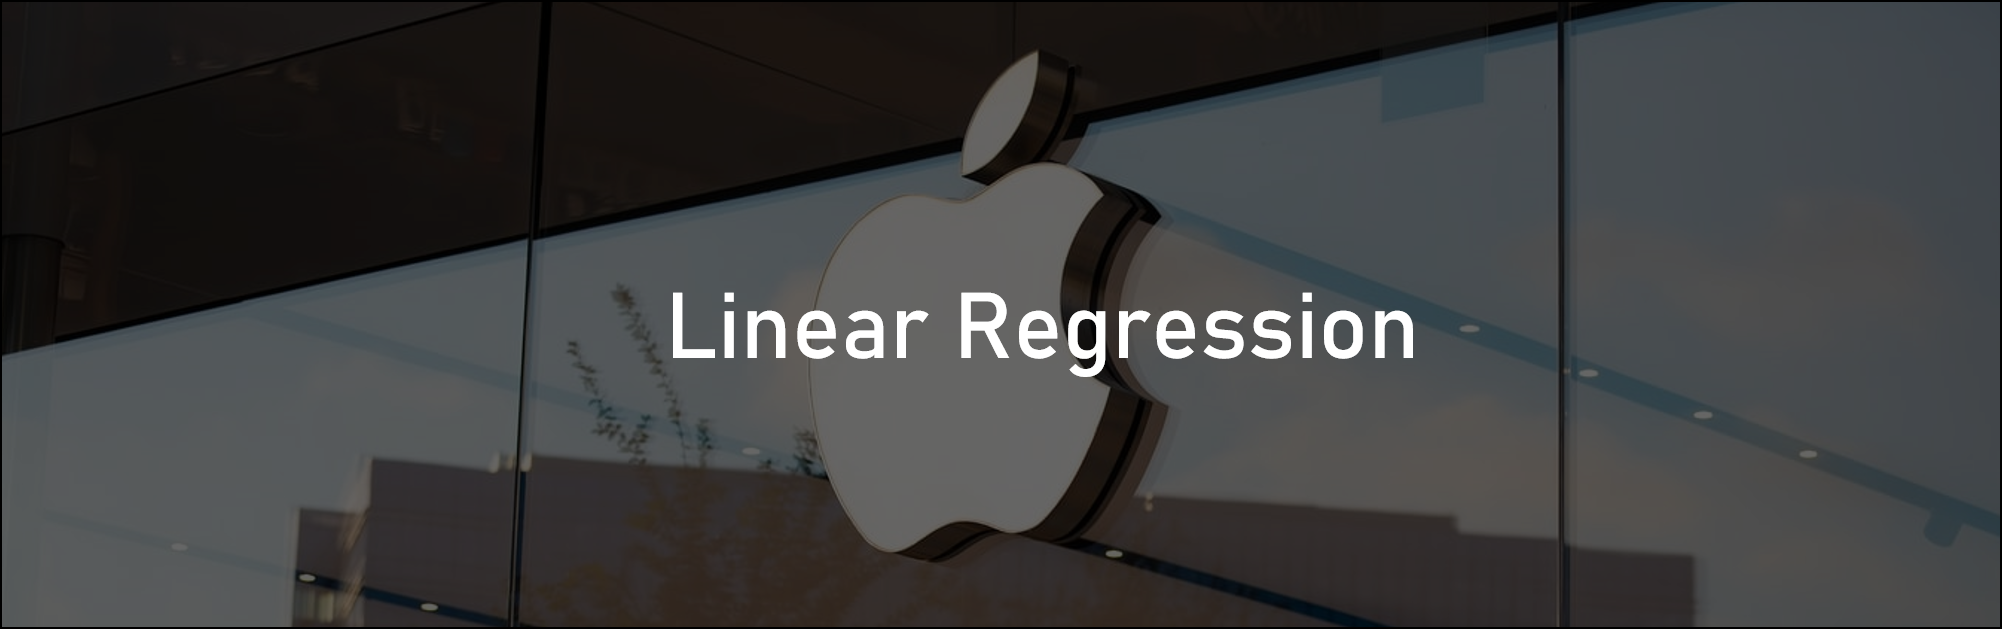

 - Linear Regression is one of the widely-used models for predictive modeling.
 - The linear regression model returns a function that determines the relationship between independent and dependent variables.

### Import necessary libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import requests as re
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Import seed for reproducibility
from numpy.random import seed
seed(1)

# For calculation
import math

# Train-Test Split Module
from sklearn.model_selection import train_test_split

# Linear Regression Algorithm from sklearn
from sklearn.linear_model import LinearRegression

# Metrics to measure model performance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# MinMax Scaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# date formatting
from datetime import datetime

# Seaborn Settings
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set(color_codes=True)
plt.style.use('seaborn-white')

%matplotlib inline

### Load the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../Stock_Price_Project/Datasets/top_50_final_eda.csv')
df.head()

,Symbol,GICS Sector,Company,Rank,Beta,Dividend Rate,Dividend Yield,Market Cap
0,AAPL,Information Technology,Apple Inc.,1.0,1.283613,0.82,0.0059,2256.00
1,MSFT,Information Technology,Microsoft Corp.,2.0,0.826155,2.24,0.0099,1682.00
2,AMZN,Consumer Discretionary,Amazon.com Inc.,3.0,1.198004,NaN,NaN,1634.00
3,FB,Communication Services,Facebook Inc. Class A,4.0,1.182773,NaN,NaN,778.04
4,TSLA,Consumer Discretionary,Tesla,5.0,2.190651,NaN,NaN,668.91


### List of Top 50 S&P 500 companies

In [3]:
# As of December 3, 2020, the following are the fifty largest S&P 500 index constituents by weight:

stock_list = list(df['Symbol'])
stock_list

['AAPL',
 'MSFT',
 'AMZN',
 'FB',
 'TSLA',
 'GOOGL',
 'GOOG',
 'JNJ',
 'JPM',
 'V',
 'PG',
 'UNH',
 'DIS',
 'NVDA',
 'MA',
 'HD',
 'PYPL',
 'VZ',
 'ADBE',
 'CMCSA',
 'NFLX',
 'BAC',
 'KO',
 'MRK',
 'PEP',
 'T',
 'PFE',
 'INTC',
 'CRM',
 'WMT',
 'ABT',
 'ABBV',
 'CSCO',
 'TMO',
 'NKE',
 'AVGO',
 'XOM',
 'QCOM',
 'COST',
 'ACN',
 'CVX',
 'MCD',
 'MDT',
 'NEE',
 'TXN',
 'HON',
 'DHR',
 'UNP',
 'BMY']

### Collect data from YahooFinance ranging from January 1, 2015 to December 30, 2020

In [4]:
# https://pypi.org/project/yfinance/

# if date today is to be used as end date:
# date_today = datetime.today().strftime('%Y-%m-%d')

sp500 = yf.download(  
        tickers = stock_list,

        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = True,
        threads = True,
        proxy = None,
        start = '2015-01-01', 
        end = '2020-12-31' #Does not include Dec. 31 in the dataset
    )

[*********************100%***********************]  49 of 49 completed


In [5]:
# Focusing only on AAPL Closing Price and Date
df2 = pd.DataFrame(sp500['AAPL']['Close'])
df2['Date'] = df2.index
df2

,Close,Date
Date,,
2014-12-31,25.137676,2014-12-31
2015-01-02,24.898552,2015-01-02
2015-01-05,24.197117,2015-01-05
2015-01-06,24.199400,2015-01-06
2015-01-07,24.538729,2015-01-07
...,...,...
2020-12-23,130.960007,2020-12-23
2020-12-24,131.970001,2020-12-24
2020-12-28,136.690002,2020-12-28


### Data Pre-processing

In [6]:
# Create a new data frame to keep only AAPL closing price using the 'Close' column
data = pd.DataFrame(sp500['AAPL']['Close'])

# Create the training data set by getting the number of rows to train the model on. Recommended is at least 80% of original set.
training_data_length = math.ceil(len(data) *.8) #use math.ceil to round up

# future days to predict
future_days = math.ceil(len(data) *.2)

# Review data length
print(future_days)

303


In [7]:
# Set future days for prediction
df2['Prediction'] = df2[['Close']].shift(-future_days) 
df2.tail(5)

,Close,Date,Prediction
Date,,,
2020-12-23,130.960007,2020-12-23,NaN
2020-12-24,131.970001,2020-12-24,NaN
2020-12-28,136.690002,2020-12-28,NaN
2020-12-29,134.869995,2020-12-29,NaN
2020-12-30,133.720001,2020-12-30,NaN


In [8]:
# Create the independent data set (x)

# Convert the dataframe to a numpy array and remove the last 'future_days' rows
x = np.array(df2.drop(['Prediction','Date'],1))[:-future_days]
x

array([[25.13767624],
       [24.89855194],
       [24.19711685],
       ...,
       [58.15171051],
       [57.91694641],
       [58.141819  ]])

In [9]:
### Create the dependent data set (y)

# Convert the dataframe to a numpy array and remove the last 'future_days' rows
y = np.array(df2['Prediction'])[:-future_days]
y

array([ 24.67772675,  24.63814163,  24.66608429, ..., 136.69000244,
       134.86999512, 133.72000122])

In [10]:
# Reshape to be same shape
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

(1208, 1) (1208, 1)


In [11]:
# Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

### Build the Model

In [12]:
# Create and train the Linear Regression Model
lr = LinearRegression()

# Train the model
lr.fit(x_train, y_train)

LinearRegression()

In [13]:
# Testing Model: Score returns the coefficient of determination R^2 of the prediction. 
# The best possible score is 1.0

lr_confidence = lr.score(x_test, y_test)
print("lr confidence: ", lr_confidence)

lr confidence:  0.6379891263113926


In [14]:
#Get the feature data, 
#AKA all the rows from the original data set except the last 'x' days
x_future = df2.drop(['Prediction','Date'], 1)[:-future_days]


In [15]:
#Get the last 'x' rows
x_future = x_future.tail(future_days) 


In [16]:
#Convert the data set into a numpy array
x_future = np.array(x_future)
x_future

array([[50.6975975 ],
       [50.22231293],
       [50.25626755],
       [50.6515274 ],
       [50.50064468],
       [50.82672119],
       [51.04087448],
       [51.16011047],
       [51.90960312],
       [52.94623184],
       [52.43034744],
       [52.32813644],
       [52.33058167],
       [52.43764877],
       [52.60068893],
       [53.03383636],
       [53.46211624],
       [54.26027298],
       [54.75912094],
       [55.39181137],
       [55.56945038],
       [55.20687485],
       [54.2894783 ],
       [53.85146332],
       [53.12874222],
       [54.47199249],
       [53.79549408],
       [55.094944  ],
       [54.46955109],
       [53.01923752],
       [53.10683823],
       [53.13846588],
       [53.54241943],
       [52.96570587],
       [53.72735977],
       [54.06803513],
       [53.63732147],
       [54.73965836],
       [54.93190384],
       [55.30177689],
       [55.79332352],
       [56.47225571],
       [55.47942352],
       [54.57904434],
       [54.45252228],
       [55

In [17]:
# Print linear regression model predictions for the next 'x_future' days
lr_prediction = lr.predict(x_future)
print(lr_prediction)

[[82.50212141]
 [81.51953014]
 [81.58972706]
 [82.40687725]
 [82.09494615]
 [82.76906844]
 [83.21180352]
 [83.45830898]
 [85.00779105]
 [87.15089095]
 [86.08436464]
 [85.87305622]
 [85.87811141]
 [86.09945923]
 [86.43652432]
 [87.33200232]
 [88.21741726]
 [89.86750624]
 [90.89881185]
 [92.20681999]
 [92.57406636]
 [91.82448691]
 [89.92788458]
 [89.02234353]
 [87.52820827]
 [90.30520979]
 [88.90663414]
 [91.59308392]
 [90.30016249]
 [87.30182103]
 [87.48292451]
 [87.54831073]
 [88.38343404]
 [87.19115107]
 [88.76577501]
 [89.47007858]
 [88.57963211]
 [90.8585754 ]
 [91.25601883]
 [92.02068498]
 [93.036896  ]
 [94.44050318]
 [92.38794713]
 [90.52652606]
 [90.26495756]
 [91.82448691]
 [86.53712334]
 [85.57625913]
 [89.42983424]
 [87.04020521]
 [89.44994458]
 [88.96701249]
 [86.36609869]
 [88.0212192 ]
 [88.69534938]
 [89.74174169]
 [85.89822175]
 [88.26773255]
 [86.50695783]
 [84.46446483]
 [84.99772799]
 [87.79483985]
 [89.48516528]
 [82.06981216]
 [79.10667564]
 [80.20337535]
 [83.31240

<ipython-input-18-843aa9a27238>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions #Create a new column called 'Predictions' that will hold the predicted prices


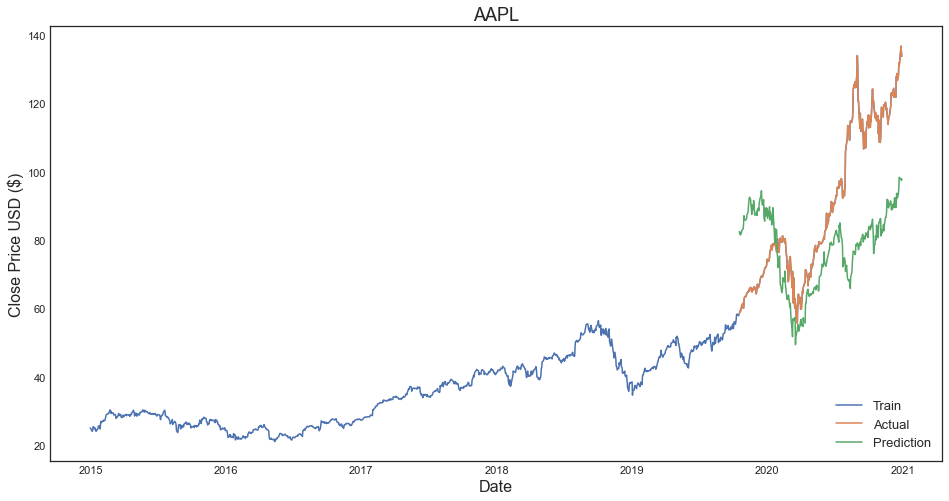

In [18]:
#Visualize the data
predictions = lr_prediction
#Plot the data
valid =  df2[x.shape[0]:]
valid['Predictions'] = predictions #Create a new column called 'Predictions' that will hold the predicted prices
plt.figure(figsize=(16,8))
plt.title('AAPL', fontsize = 18)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Close Price USD ($)',fontsize=16)
plt.plot(df2['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Actual', 'Prediction' ], loc='lower right', fontsize = 13)
plt.show()

### Performance Metrics

In [19]:
#Create function to generate performance metrics

def measure_performance(actual,predicted):
    r2 = r2_score(actual, predicted)
    mae = mean_absolute_error(actual, predicted) 
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    print(("r2: %.2f") %r2)
    print(("mae: %.2f") %mae)
    print(("rmse: %.2f") %rmse)

In [20]:
#Measure the performance of the model
measure_performance(x_future, lr_prediction)

r2: -29.01
mae: 29.25
rmse: 29.82


In [21]:
# Show the actual prices with the added column for predicted prices
df3 = df2.drop(['Prediction', 'Date'], 1)
actual_price = df3[-(future_days):]
actual_price['Predictions'] = lr_prediction
actual_price.tail(10)

<ipython-input-21-f166f5cbbe4a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_price['Predictions'] = lr_prediction


,Close,Predictions
Date,,
2020-12-16,127.809998,93.667099
2020-12-17,128.699997,93.692651
2020-12-18,126.660004,92.333689
2020-12-21,128.229996,93.677320
2020-12-22,131.880005,95.240635
2020-12-23,130.960007,98.367248
2020-12-24,131.970001,98.193542
2020-12-28,136.690002,97.912565
2020-12-29,134.869995,97.427220
